In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 基础RNN网络

## 1. 生成数据集

试试单变量时间序列预测，假设每个周期都有51个步长，要求预测第51个步长的数值

In [2]:
# 生成数据集，需指定批大小以及一个周期内的时间步长步数
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
# 只预测这7000个周期的后一个值
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


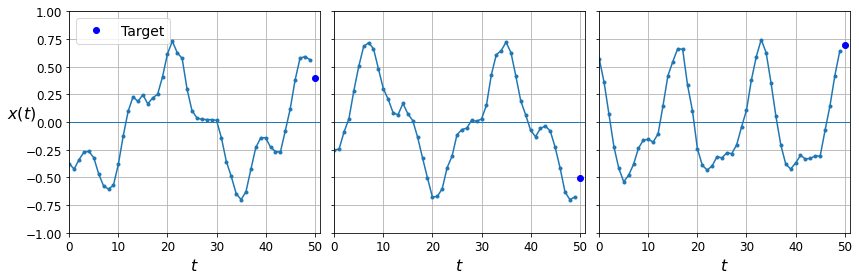

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**注意：** 本节中蓝点代表实际目标值，红叉代表预测值

## 2. 得到Baselines

最简单的预报方法，将每个周期的第50个值当成第51个值做预报

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

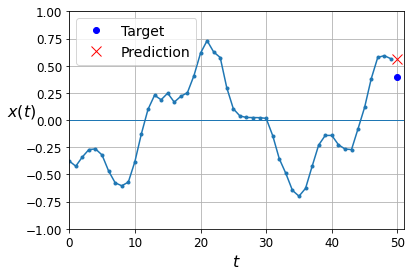

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

接下来使用一个简单的全连接实现一个多元回归看看MSE

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # 在输入的时候需要使用Flatten将每个周期拆分出来
    # 需要指定每个周期的行数
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
# 可见多元线性回归的效果明显比之前的方法MSE小一些
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

看看学习曲线

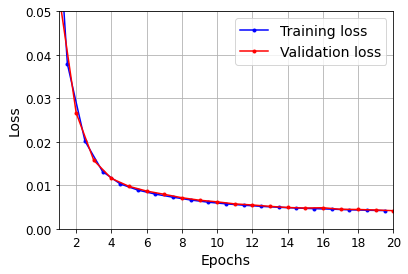

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

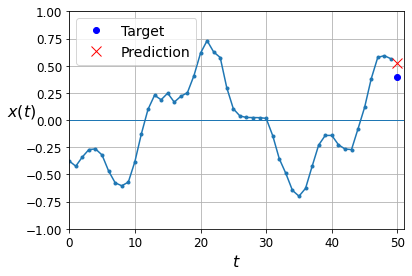

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 3. 创建简单的RNN网络

RNN默认使用tanh作为激活函数，但是也是可以手动设置使用ReLu作为激活函数的  
对于该例的RNN网络预测最后一个样本值（从序列到向量），要记得它的一个样本就是一个周期，也就是大小是[timesteps, features]的矩阵,这里的一个周期只有一种feature，所以向其传入的是三维张量[batchsize, timesteps, features]，和普通全连接神经网络传入二维矩阵是不一样的

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # 在创建RNN网络时，不需要指定每个周期的步长，其可以处理任意长度的步长
    # 当时需要指定特征变量的个数
    # 只预测一个值，所以只有一个神经元
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 34s 152ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 32s 148ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 32s 148ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 32s 147ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 32s 148ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 32s 147ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 32s 148ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 32s 146ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 33s 149ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 32s 147ms/step - l

In [13]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
#simple_rnn = tf.keras.layers.SimpleRNN(1)
simple_rnn = tf.keras.layers.SimpleRNN(4, return_sequences=True, return_state=True)

whole_sequence_output, final_state = simple_rnn(inputs)
#output = simple_rnn(inputs)
#output.shape

可以看到，虽然最比最简单的预测方法的MSE误差要小，但是还是比不过多元回归  
不过要注意的是，刚才那个神经网络实现的多元回归方法有51个参数（50+1个偏置项）  
而刚才创建的简单的只有一个RNN神经元的网络，只有3个参数，分别是输入的参数、隐藏输入（基于上一个步长的输出得到） 和 一个偏置项

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 18ms/step - loss: 0.0109


0.010881561785936356

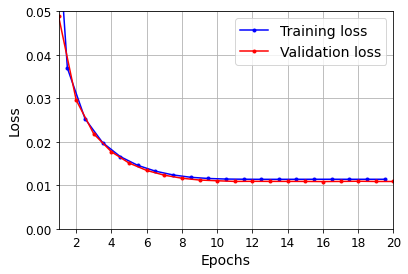

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

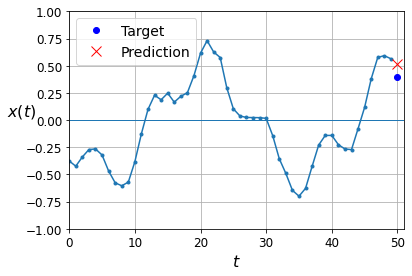

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# 深度RNN网络

刚才的RNN网络表现不好是很正常的，毕竟只有一个RNN层，接下来看看多个RNN堆叠起来的效果

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # 记得在除最后一层之外的层都加上return_sequences=True
    # 不然后面的层会只接收到2D张量(每个批的最后一个向量或值)，而RNN需要3D张量(每个批的所有输出)
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 112s 504ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 110s 504ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 109s 500ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 110s 502ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 110s 501ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 110s 501ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 111s 507ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 113s 517ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 113s 518ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 114s 519m

可见堆叠后的深度RNN网络的效果明显是比线性模型要好很多的

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 4s 56ms/step - loss: 0.0029


0.0029105590656399727

同时可见其学习曲线，其损失下降的速度也非常快

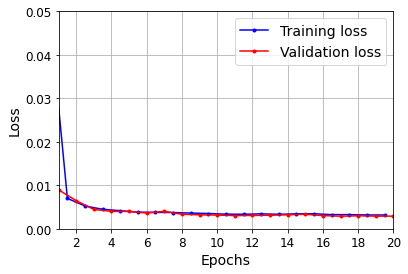

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

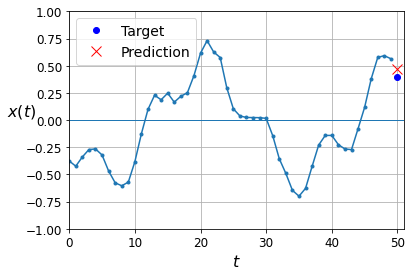

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

但并不是说这个网络就很好，最后的一个RNN层的并不是很合理。  
因为只有一个神经元，意味着隐藏状态的输入可能只有一个值，这用处可能不大，保留的信息比较少。  
而且因为默认状态下RNN使用tanh作为激活函数，所以预测值就只能是在[-1, 1]区间内，如果要使用其他激活函数的话最好还是使用一个Dense层作为输出  
  
使用Dense层作为输出并不会降低网络的性能并且还能提高计算速度

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    # 记得把输出Dense层之前一层的RNN层的return_sequences=True去掉
    # 因为密集层接收的是2D的张量
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 78s 349ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 76s 349ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 78s 354ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 77s 351ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 77s 353ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 77s 350ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 77s 350ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 75s 344ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 76s 347ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 76s 348ms/step - l

可见网络的性能确实没有下降多少，甚至还更好一些

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 3s 39ms/step - loss: 0.0026


0.002623624401167035

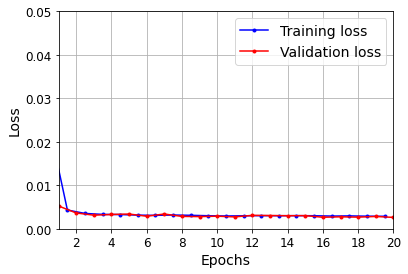

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

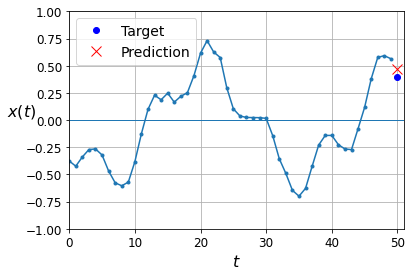

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# 预测未来多个时间步长

一个简单的方法是：还是一次计算只预测一个步长，将预测的值加入到输入中然后再进行计算  
就比如下面的例子。还是使用原有的模型，预测未来十个步长的数据

In [36]:
np.random.seed(43) # 不能选42了。不然会和之前的序列一样

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [37]:
Y_pred.shape

(1, 10, 1)

这种做法的弊端就是，误差会随着预测步长的增加而累积。所以这种方法并不适用于预测太多的步长

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

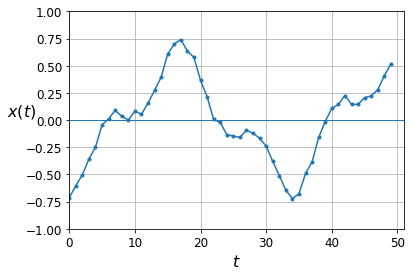

In [54]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

接下来来使用原有的序列数据来测试这种方法预测未来10个步长的MSE误差

In [38]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [39]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [40]:
Y_pred.shape

(2000, 10)

In [41]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510826

来和之前的两个baselines方法对比一下误差  
很明显是比单纯将最后的一个值复制10遍的效果要好，但是没有多元回归的效果好

In [42]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0222

接下来就可以使用第二种方法了，还是序列到向量的思路，不过这次是同时输出10个预测结果(长为10的向量)，这需要在原有的基础上将最后一层神经元的数量设置为10

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 80s 355ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 80s 364ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 79s 360ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 79s 359ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 79s 361ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 78s 357ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 77s 353ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 77s 353ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 75s 345ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 76s 348ms/step - l

可以发现这次的效果明显是比前面的多元回归要好很多  
随便那一个周期的数据来预测看看效果：

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

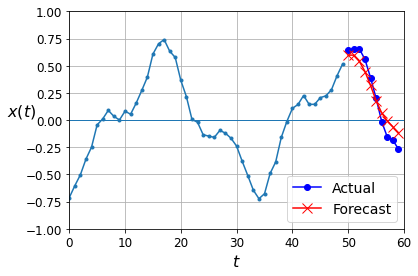

In [57]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

但是这还不是终点，单变量RNN还能做的更好，比如使用从序列到序列的RNN模型。  
  
也就是说不只是像现在一样只考虑一个周期内最后一个时间步长的计算结果(输出项)，而是考虑每个时间步长的输出项(在此例中是每个步长都可以输出10个未来时间步长)  
  
这么做的好处是，损失将包含每个步长的误差，将会有更多的误差梯度流经整个模型，梯度不再像之前那样随着一个个周期流淌，而是从每个步长中流出，这会加速训练  
  
也就是说，在本例中，一个周期内：
时间步长为0时会输出一个向量，其中包含时间步长1到10的预测；  
时间步长为1时会输出一个向量，其中包含时间步长2到11的预测；  
因此目标变量每个步长必须是包含10个真实步长数据的10维向量，这与之前每个周期才有10个不一样，新的目标变量将是变成3维的，即[批大小, 时间步长, 10]就像下面这样

In [58]:
np.random.seed(42)

# 其实输入段的数据形状不用变，需要变的只有目标变量的数据形状
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# 接下来来创建新的目标变量数据，是3维的
Y = np.empty((10000, n_steps, 10))
# 这就像是一个移动窗口，放入每个时间步长未来10个步长的实际数据
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [59]:
# 可以看到，目标变量的形状变成了3维的
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    # 其实只要在输出层前的RNN层配置return_sequences=True就能返回每个步长的输出序列了
    keras.layers.SimpleRNN(20, return_sequences=True),
    # 此时输入的形状是[批大小, 时间步长, 20]
    # 所以需要使用TimeDistributed装饰层，来使密集层的输入形状变成[批大小 * 时间步长, 20]
    # 也就是相当于将每个步长都当成一个实例
    # 最后再将结果变成[批大小, 时间步长, 10]
    
    # TimeDistributed(keras.layers.Dense(10))其实等效于Conv1D(10, filter_size=1)
    # 并且其实不加TimeDistributed装饰，密集层也能这么运作
    # 但是为了可读性，还是加上比较好，以方便让人理解这是在将每个步长都当做一个实例
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# 虽然这次是考虑了每个步长的损失，但是其实在最后只体现最后一个预测结果的误差就行
# 尽管这样其实也不算公平，因为上一个RNN模型计算的是每个周期的后10个预测结果的误差
# 而这次计算每个周期50个预测结果的误差（每个时间步长对应一个预测值）
# 但尽管这样，这个新的RNN模型依然比上一个好很多
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 76s 338ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 74s 337ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0352 - val_last_time_step_mse: 0.0245
Epoch 3/20
219/219 [==============================] - 75s 341ms/step - loss: 0.0326 - last_time_step_mse: 0.0215 - val_loss: 0.0362 - val_last_time_step_mse: 0.0258
Epoch 4/20
219/219 [==============================] - 76s 346ms/step - loss: 0.0297 - last_time_step_mse: 0.0186 - val_loss: 0.0282 - val_last_time_step_mse: 0.0162
Epoch 5/20
219/219 [==============================] - 75s 342ms/step - loss: 0.0274 - last_time_step_mse: 0.0156 - val_loss: 0.0267 - val_last_time_step_mse: 0.0163
Epoch 6/20
219/219 [==============================] - 75s 340ms/step - loss: 0.0249 - last_time_step_mse: 0.0121 - val_loss: 0.0230 - val_last_time_step_mse: 0.0097
Epoch 7/20

可以看到，最好的验证集的误差只有0.006，比之前的结果还要好  
通过可视化也可以发现这个新的模型的效果肉眼可见的好

In [69]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

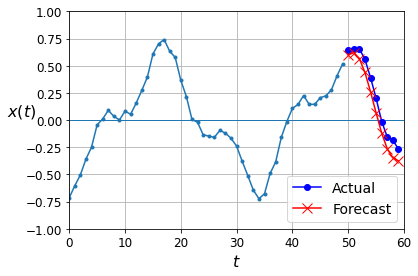

In [70]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 自定义一个RNN层

In [79]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
        
    # 如果输入的神经元对象没有设置初始
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [80]:
myRNN = MyRNN(10)

10


In [78]:

myRNN(X_train)

Tensor("inputs:0", shape=(7000, 50, 1), dtype=float32)


AttributeError: Exception encountered when calling layer "my_rnn_1" (type MyRNN).

in user code:

    File "C:\Users\Forecast\AppData\Local\Temp\ipykernel_16616\3310226414.py", line 14, in call  *
        states = self.get_initial_state(inputs)
    File "C:\Users\Forecast\AppData\Local\Temp\ipykernel_16616\3310226414.py", line 11, in fallback_initial_state  *
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]

    AttributeError: 'int' object has no attribute 'state_size'


Call arguments received:
  • inputs=tf.Tensor(shape=(7000, 50, 1), dtype=float32)